In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

from matplotlib import rc
rc('text', usetex=True)
rc('pdf', fonttype=42)
rc('ps', fonttype=42)
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

THIS_DIR = os.path.dirname(os.path.realpath("__file__"))
FIG_DIR = os.path.join(THIS_DIR, "figures")
SAVE_DIR = os.path.join(THIS_DIR, "results")
os.makedirs(FIG_DIR, exist_ok=True)

In [2]:
ts = np.linspace(0, 1, 481)[:-1]
ts_brax = np.linspace(0, 1, 241)[:-1]

## get analytical optimal control according to Hu et al. https://arxiv.org/abs/2205.08622

In [3]:
def get_vc_cost(s):
    eps = 0.1
    dc = 1 - (0.2 * 2) / np.sqrt(2)
    a = 8 * eps / s + 2 * (1 - s) * (1 - s)
    b = - (4 * (1 - s) + 24 * eps * dc / (s ** 2))
    c = 2 + 24 * eps * dc ** 2 / (s ** 3)
    vc = - b / (2 * a)
    cost = a * vc ** 2 + b * vc + c
    return vc, cost

t = np.linspace(0.01, 0.99, 100)
v, cost = get_vc_cost(t)
idx = np.argmin(cost, 0)
s = t[idx]
vc = v[idx]
dc = 1 - (0.2 * 2) / np.sqrt(2)
t_ = ts[ts < s]
u_ = 6 * dc / (s ** 2) - 2 * vc / s + (6 * vc / (s ** 2) - 12 * dc/ (s ** 3)) * t_
t_rest = ts[ts>=s]
u_rest = np.zeros_like(t_rest)
u_opt = np.concatenate((u_, u_rest))

## load results from differentiable simulators

In [4]:
exp_names = OrderedDict([
    ("two_balls_1_pbd_warp", "PBD (Warp)"),
    ("two_balls_1_pbd_brax", "PBD (Brax)"),
    ("two_balls_1_soft_warp_kn_10000.0", "Compliant (Warp)"),
    ("two_balls_1_soft_brax", "Compliant (Brax)"),
    ("two_balls_1_convexopt_diffcosim_symplectic_euler_w_toi", "Convex (w/ TOI)"),
    ("two_balls_1_convexopt_diffcosim_symplectic_euler_wo_toi", "Convex (w/o TOI)"),
    ("two_balls_1_specialized_difftaichi_w_toi", "Direct (w/ TOI)"),
    ("two_balls_1_specialized_difftaichi_wo_toi", "Direct (w/o TOI)"),
    ("two_balls_1_lcp_nimble", "LCP (w/ TOI)"),
])
kwargs = OrderedDict([
    ("two_balls_1_convexopt_diffcosim_symplectic_euler_w_toi", {"color": "#c15924", "linestyle": "dashed"}),
    ("two_balls_1_convexopt_diffcosim_symplectic_euler_wo_toi", {"color": "#ffc13d", "linestyle": "dashed"}),
    ("two_balls_1_specialized_difftaichi_w_toi", {"color": "#1428d6", "linestyle": "dotted"}),
    ("two_balls_1_specialized_difftaichi_wo_toi", {"color": "#488ff0", "linestyle": "dotted"}),
    ("two_balls_1_pbd_brax", {"color": "#009999", "linestyle": (0, (3, 1, 1, 1, 1, 1)), "linewidth": 2}),
    ("two_balls_1_pbd_warp", {"color": "#6dbd2c", "linestyle": "solid"}),
    ("two_balls_1_lcp_nimble", {"color": "#663300", "linestyle": "solid"}),
    ("two_balls_1_soft_brax", {"color": "#a01cff", "linestyle": "dashdot"}),
    ("two_balls_1_soft_warp_kn_10000.0", {"color": "#cc99ff", "linestyle": "solid"}),
])

In [5]:
results = OrderedDict()
for name, _ in exp_names.items():
    npzfile = np.load(os.path.join(SAVE_DIR, name+".npz"))
    results[name] = {}
    results[name]['loss'] = npzfile['loss']
    results[name]['ctrls'] = npzfile['ctrls']
    

In [6]:
results["two_balls_1_lcp_nimble"]['loss'].shape

(1000,)

## Plots

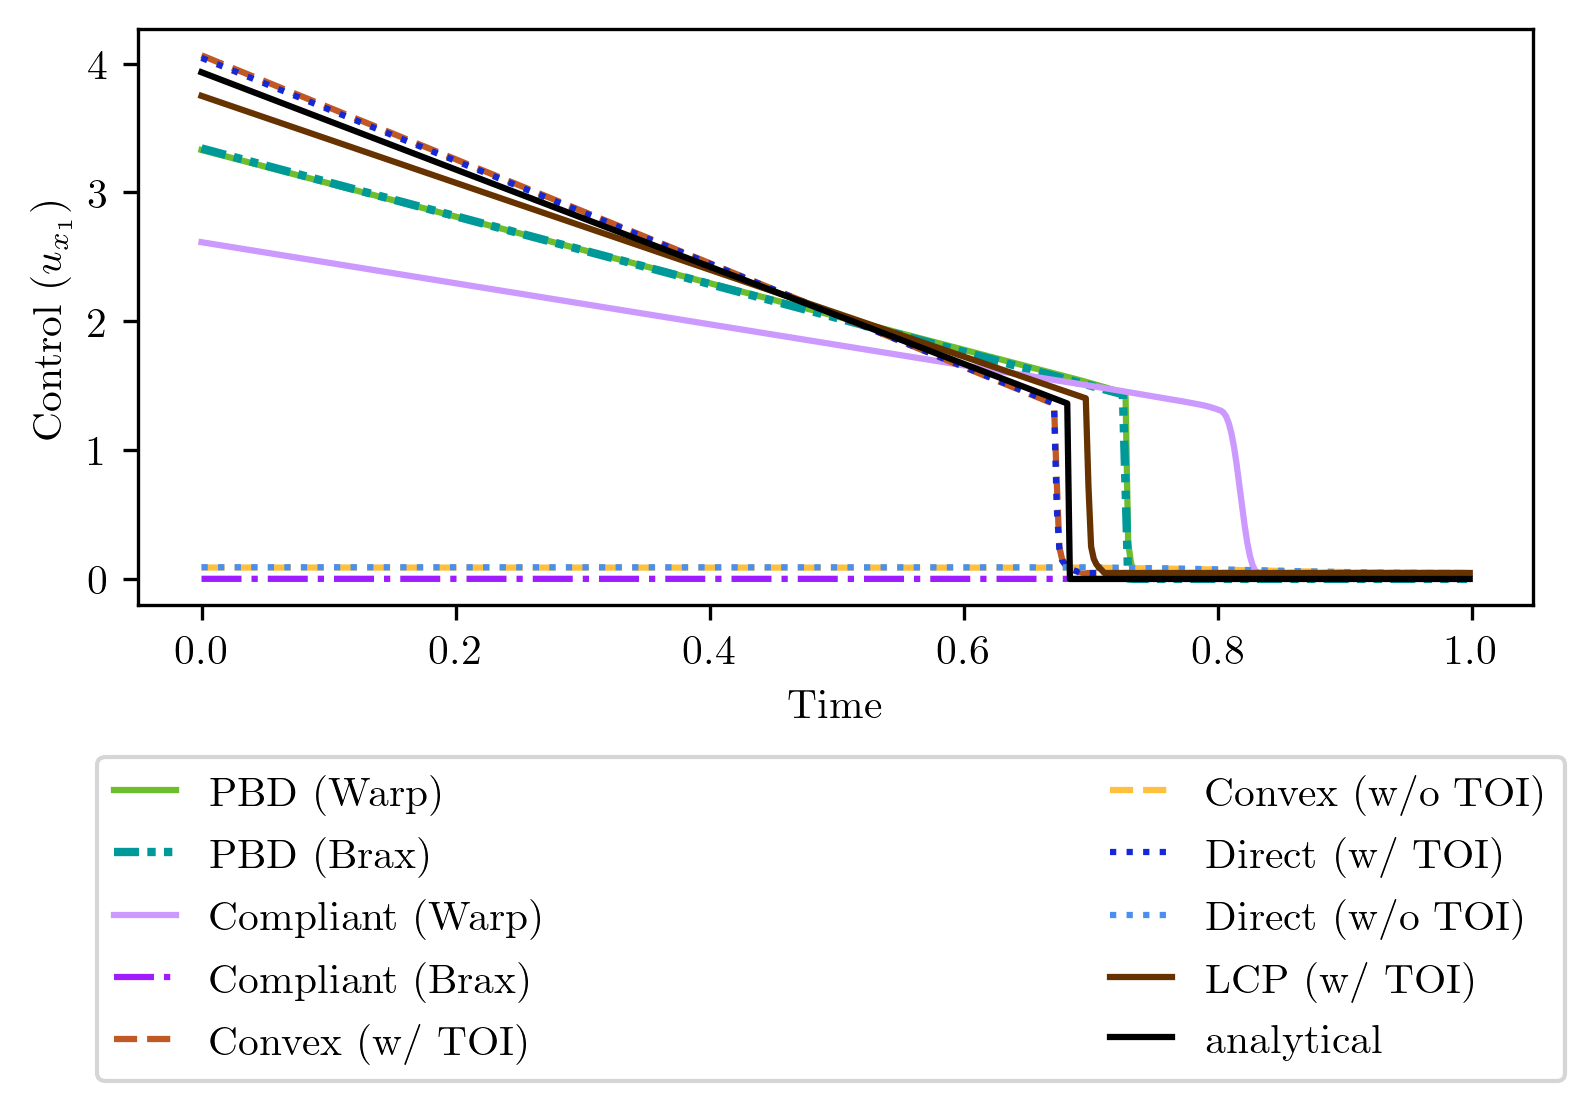

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
for name, label in exp_names.items():
    if 'brax' in name:
        ax.plot(ts_brax, results[name]['ctrls'][:, 0], label=label, **kwargs[name])
    else:
        ax.plot(ts, results[name]['ctrls'][:, 0], label=label,**kwargs[name])
ax.plot(ts, u_opt, label="analytical", color='k')
ax.set_ylabel("Control ($u_{x_1}$)")
ax.set_xlabel("Time")
# create legend 
fig.subplots_adjust(bottom=0.40)
_, labels = ax.get_legend_handles_labels()
fig.legend(labels=labels, 
           bbox_to_anchor=(0.10, 0., 0.82, 0.), 
           loc="lower center", 
           ncol=2, 
           borderaxespad=0.1, 
           mode="expand", 
           handlelength=1.5,
           fontsize=10)
# fig.savefig(os.path.join(FIG_DIR, "two_balls_ctrls.png"), bbox_inches="tight")


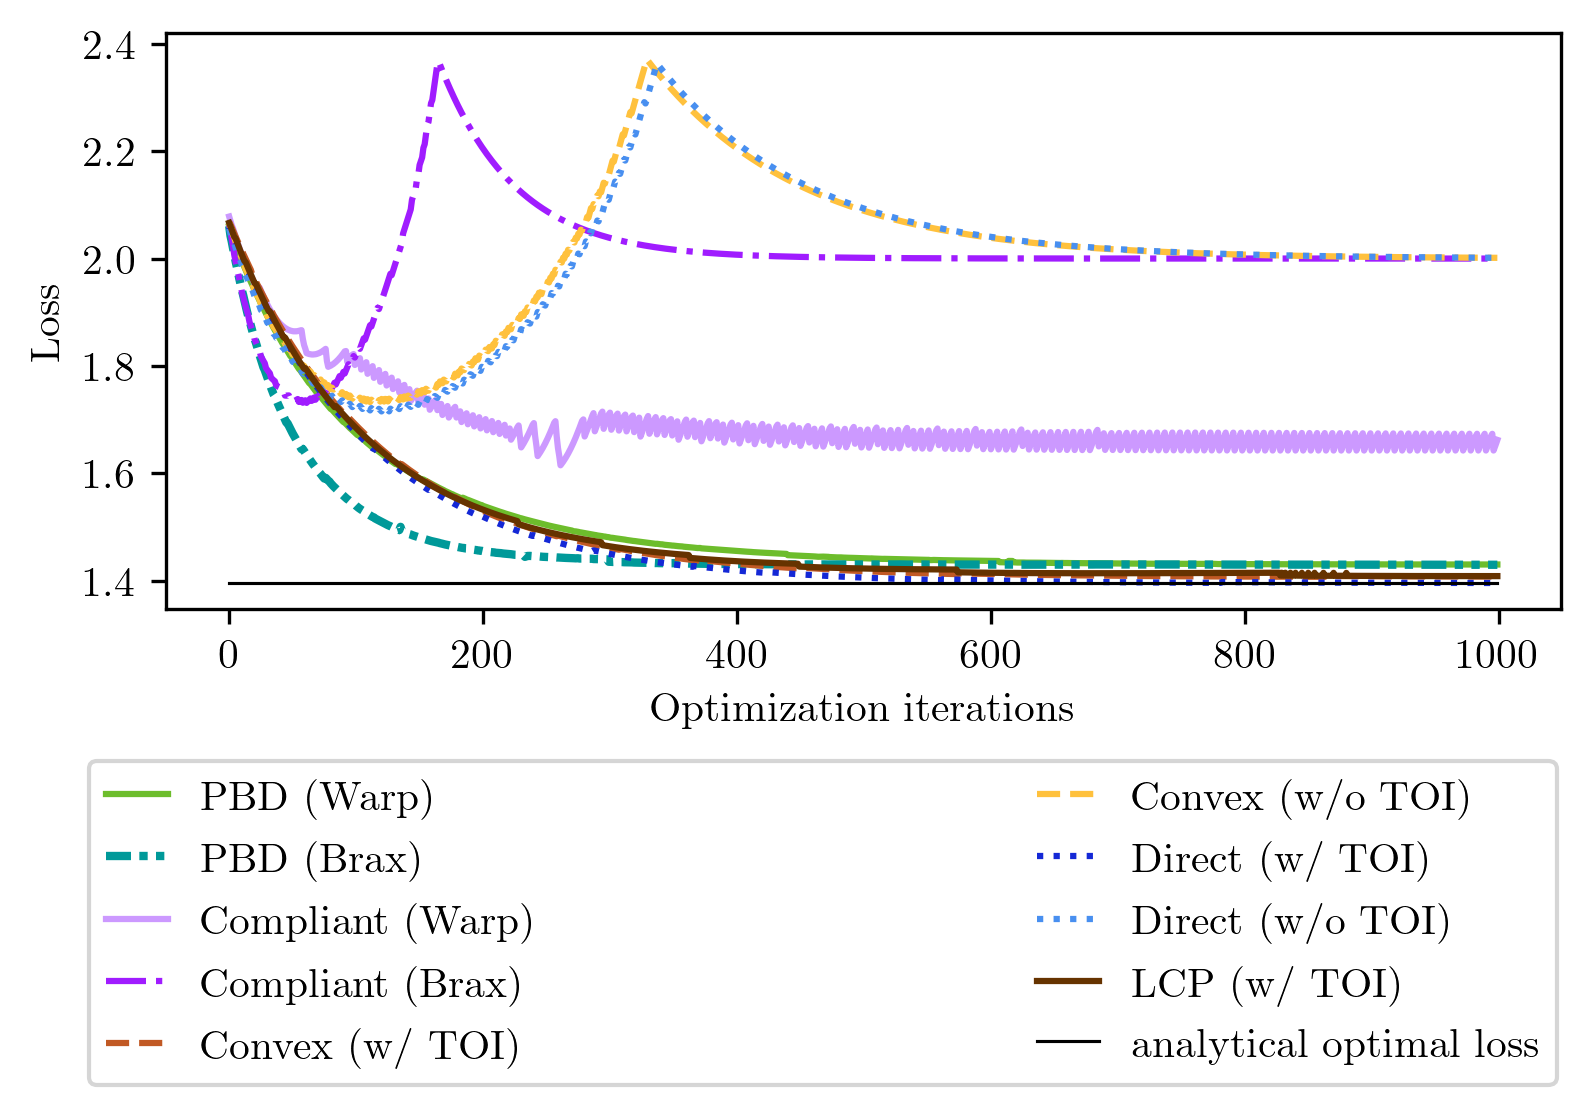

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
for name, label in exp_names.items():
    ax.plot(results[name]['loss'], label=label, **kwargs[name])
ax.plot(np.ones(1000) * 1.396542, color='k', linewidth=0.75, label="analytical optimal loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Optimization iterations")
# ax.legend()
# create legend 
fig.subplots_adjust(bottom=0.40)
_, labels = ax.get_legend_handles_labels()
fig.legend(labels=labels, 
           bbox_to_anchor=(0.08, 0., 0.82, 0.), 
           loc="lower center", 
           ncol=2, 
           borderaxespad=0.1, 
           mode="expand", 
           handlelength=1.5,
           fontsize=10)
# fig.savefig(os.path.join(FIG_DIR, "two_balls_learning_curve.png"), bbox_inches="tight")

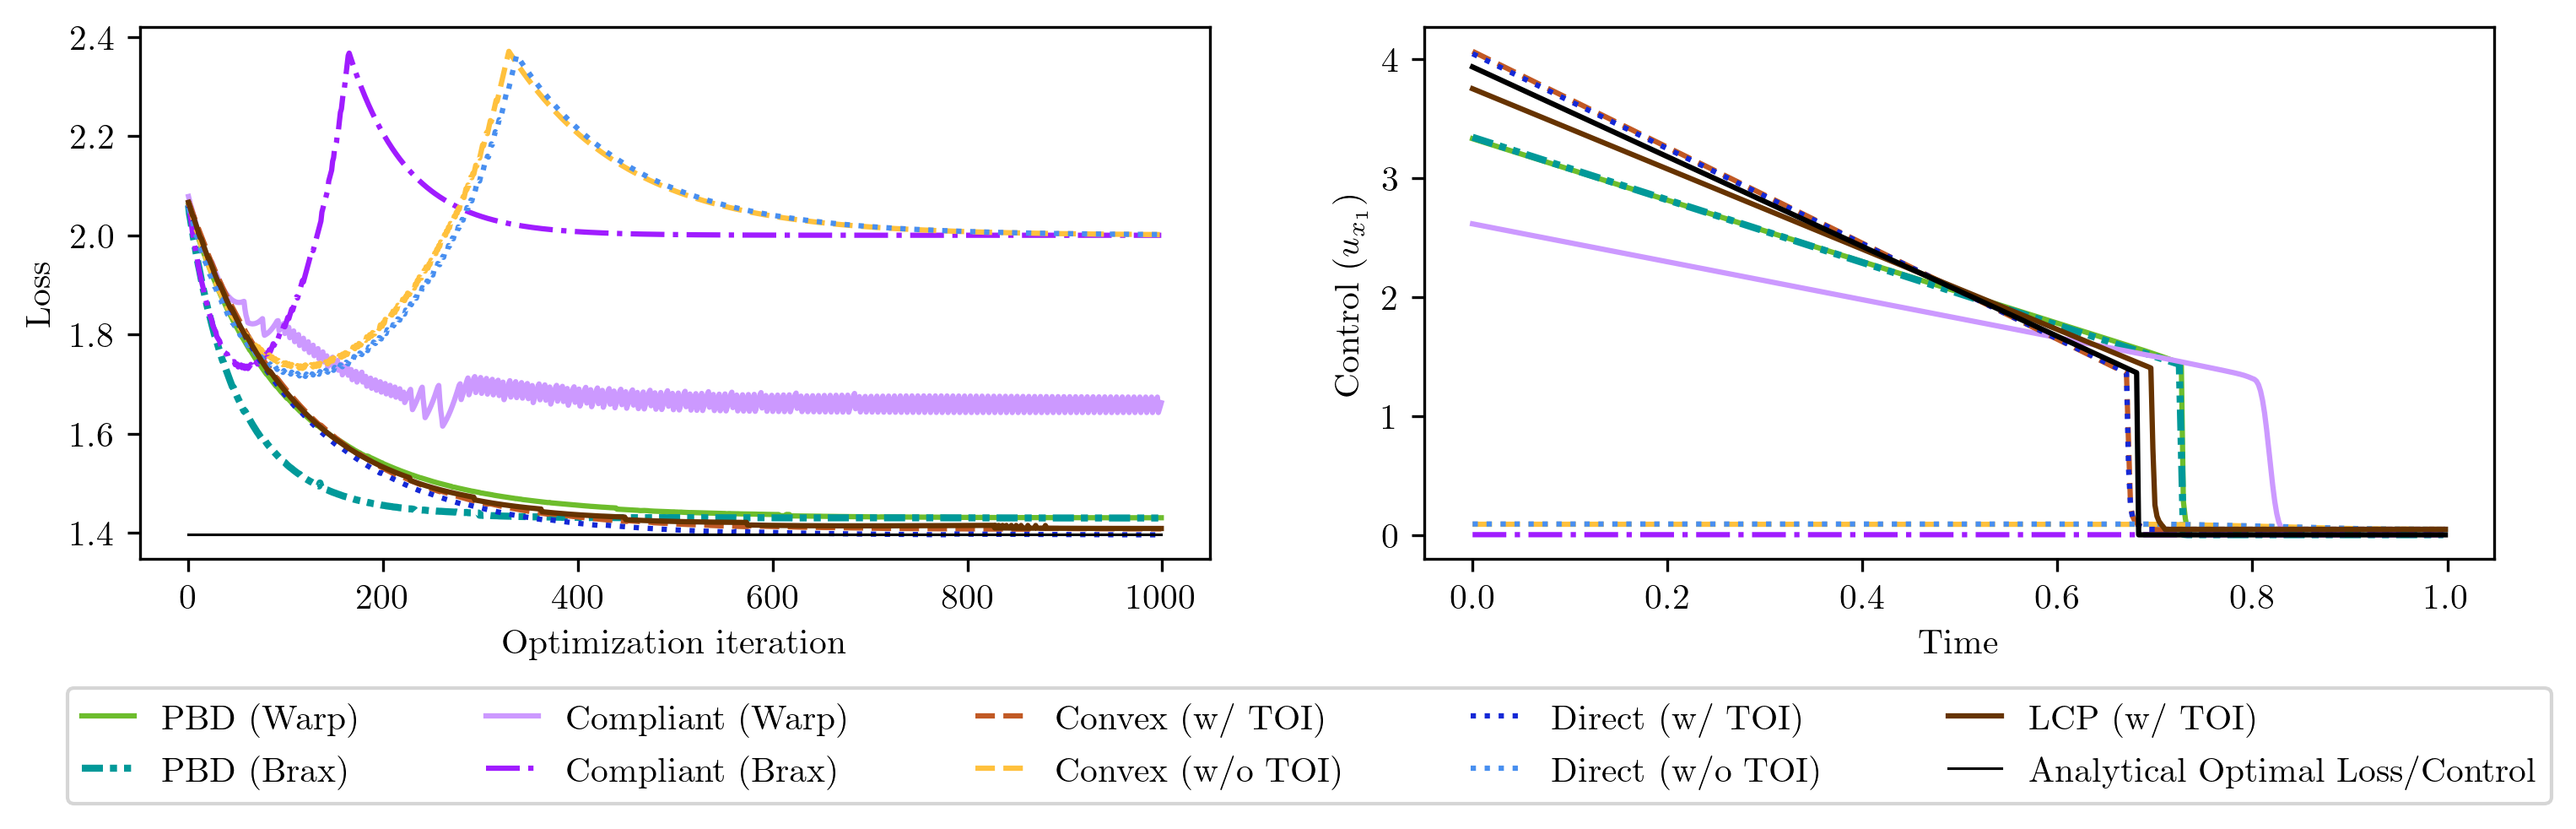

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), dpi=300)

for name, label in exp_names.items():
    axes[0].plot(results[name]['loss'], label=label, **kwargs[name])
axes[0].plot(np.ones(1000) * 1.396542, color='k', linewidth=0.75, label="Analytical Optimal Loss/Control")
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Optimization iteration")

for name, label in exp_names.items():
    if 'brax' in name:
        axes[1].plot(ts_brax, results[name]['ctrls'][:, 0], label=label, **kwargs[name])
    else:
        axes[1].plot(ts, results[name]['ctrls'][:, 0], label=label,**kwargs[name])
axes[1].plot(ts, u_opt, label="analytical", color='k')
axes[1].set_ylabel("Control ($u_{x_1}$)")
axes[1].set_xlabel("Time")


# create legend 
fig.subplots_adjust(bottom=0.28)
_, labels = axes[0].get_legend_handles_labels()
fig.legend(labels=labels, 
           bbox_to_anchor=(0.10, 0., 0.82, 0.), 
           loc="lower center", 
           ncol=5, 
           borderaxespad=0.1, 
           mode="expand", 
           handlelength=1.5,
           fontsize=10)
# fig.savefig(os.path.join(FIG_DIR, "two_balls_loss_ctrls.png"), bbox_inches="tight")

In [10]:
for name, label in exp_names.items():
    print(name, results[name]['loss'][-1])

two_balls_1_pbd_warp 1.4302428
two_balls_1_pbd_brax 1.4297202
two_balls_1_soft_warp_kn_10000.0 1.6622765
two_balls_1_soft_brax 2.0000002
two_balls_1_convexopt_diffcosim_symplectic_euler_w_toi 1.4078553915023804
two_balls_1_convexopt_diffcosim_symplectic_euler_wo_toi 2.0013787746429443
two_balls_1_specialized_difftaichi_w_toi 1.39581298828125
two_balls_1_specialized_difftaichi_wo_toi 2.00144362449646
two_balls_1_lcp_nimble 1.4086288577968151


## change spring stiffness in compliant models

Text(0.5, 0, 'Optimization iteration')

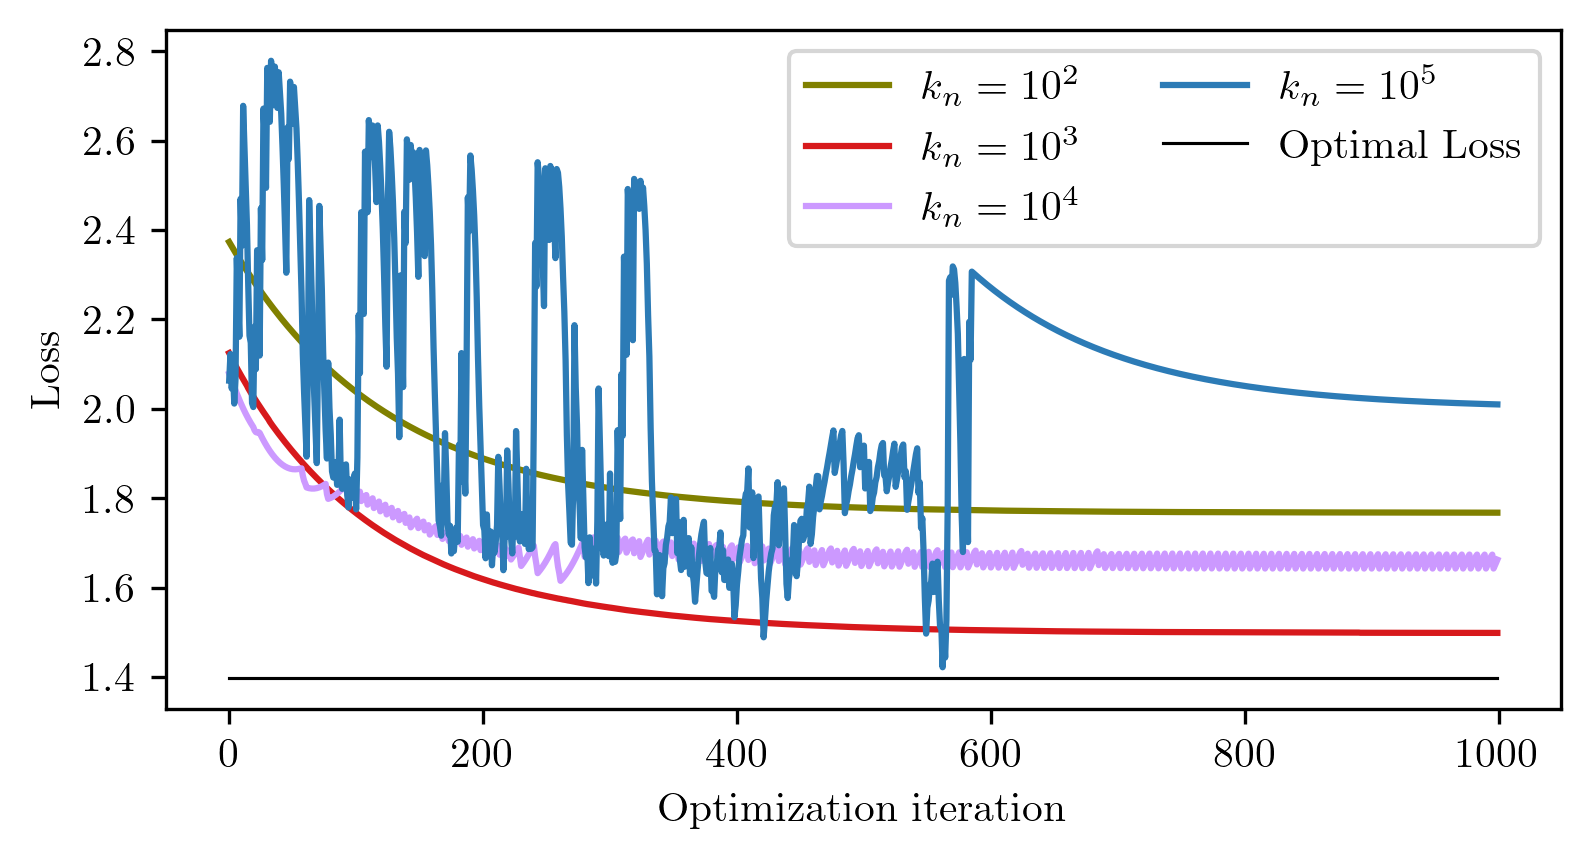

In [11]:
soft_exp_names = {
    "two_balls_1_soft_warp_kn_100": "soft_warp_kn_1.e+2",
    "two_balls_1_soft_warp_kn_1000.0": "soft_warp_kn_1.e+3",
    "two_balls_1_soft_warp_kn_10000.0": "soft_warp_kn_1.e+4",
    "two_balls_1_soft_warp_kn_100000.0": "soft_warp_kn_1.e+5",
}
soft_results = {}
for name, _ in soft_exp_names.items():
    npzfile = np.load(os.path.join(SAVE_DIR, name+".npz"))
    soft_results[name] = {}
    soft_results[name]['loss'] = npzfile['loss']
    soft_results[name]['ctrls'] = npzfile['ctrls']
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)
ax.plot(soft_results["two_balls_1_soft_warp_kn_100"]['loss'], label="$k_n=10^2$", color="olive", linestyle="solid")
ax.plot(soft_results["two_balls_1_soft_warp_kn_1000.0"]['loss'], label="$k_n=10^3$", color="#d7191c", linestyle="solid")
ax.plot(soft_results["two_balls_1_soft_warp_kn_10000.0"]['loss'], label="$k_n=10^4$", color="#cc99ff", linestyle="solid")
ax.plot(soft_results["two_balls_1_soft_warp_kn_100000.0"]['loss'], label="$k_n=10^5$", color="#2c7bb6", linestyle="solid")
ax.plot(np.ones(1000) * 1.396542, color='k', linewidth=0.75, label="Optimal Loss")
ax.legend(ncol=2)
ax.set_ylabel("Loss")
ax.set_xlabel("Optimization iteration")
# fig.savefig(os.path.join(FIG_DIR, "two_balls_compliant_learning_curve.png"), bbox_inches="tight")

## Analytical optimal control

In [12]:
def get_vc_cost(s):
    eps = 0.1
    dc = 1 - (0.2 * 2) / np.sqrt(2)
    a = 8 * eps / s + 2 * (1 - s) * (1 - s)
    b = - (4 * (1 - s) + 24 * eps * dc / (s ** 2))
    c = 2 + 24 * eps * dc ** 2 / (s ** 3)
    vc = - b / (2 * a)
    cost = a * vc ** 2 + b * vc + c
    return vc, cost


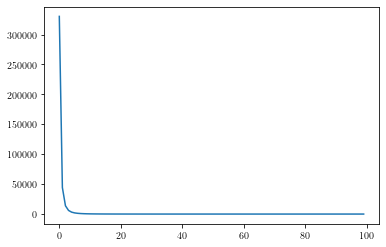

In [13]:
t = np.linspace(0.01, 0.99, 100)
v, cost = get_vc_cost(t)
plt.plot(cost)

In [14]:
idx = np.argmin(cost, 0)

In [15]:
s = t[idx]

In [16]:
vc = v[idx]

In [17]:
dc = 1 - (0.2 * 2) / np.sqrt(2)
t_ = ts[ts < s]
u_ = 6 * dc / (s ** 2) - 2 * vc / s + (6 * vc / (s ** 2) - 12 * dc/ (s ** 3)) * t_
t_rest = ts[ts>=s]
u_rest = np.zeros_like(t_rest)
opt_u = np.concatenate((u_, u_rest))

In [18]:
u_rest.shape

(152,)

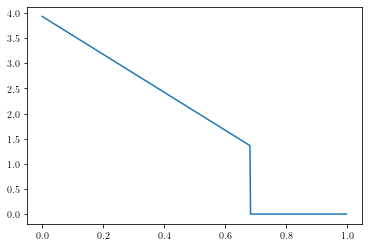

In [19]:
plt.plot(ts, opt_u)

## Calculating analytical gradients using JAX 

The mathematical expressions for gradients can be derived, but they are complicated. Here we provide two code snippets calculate them numerically. 

In [20]:
# dl/dx10 = 2 * x2T (2 - T/s)
# dl/dx20 = 2 * x2T (T/s - 1)
# dl/dx10 + dl/dx20 = 2 * x2T

import jax
import jax.numpy as jnp
import numpy as np
def loss_fn(x, u_c=3*jnp.sqrt(2), r=0.2, T=1.):
    x1_0 = x[0]
    x2_0 = x[1]
    # time of collision
    s = jnp.sqrt(2 * (x2_0 - x1_0 - 2 * r) / u_c)
    # velocity at time of collision
    v1_s = u_c * s
    x2_T = x2_0 + v1_s * (T - s)
    # x2T = x20 + jax.lax.stop_gradient(v) * (T - s)
    l = x2_T ** 2
    return l, (s, v1_s, x2_T)

grad_loss_fn = jax.grad(loss_fn, has_aux=True)
x0 = jnp.array([-2 * jnp.sqrt(2), -1 * jnp.sqrt(2)])
dl_dx, aux_data = grad_loss_fn(x0)
s, v, x2T = aux_data
print(f"dl/dx10: {(dl_dx)}")
print(f"2 * x2T (2 - T/s): {2 * x2T * (2 - 1./ s)}")
print(f"2 * x2T (T/s - 1): {2 * x2T * (1./ s - 1)}")
print(f"x2T: {2 * x2T}")
print("")
print("rotate gradients back to the original coordinate frame")
print((dl_dx)/ jnp.sqrt(2))
print(2 * x2T / jnp.sqrt(2))
print(aux_data)

dl/dx10: [-0.5638024 -0.4543205]
2 * x2T (2 - T/s): -0.5638024806976318
2 * x2T (T/s - 1): -0.45432043075561523
x2T: -1.018122911453247

rotate gradients back to the original coordinate frame
[-0.39866853 -0.3212531 ]
-0.71992165
(DeviceArray(0.6914513, dtype=float32), DeviceArray(2.9335794, dtype=float32), DeviceArray(-0.50906146, dtype=float32))


In [21]:
import jax
import jax.numpy as jnp
import numpy as np
def loss_fn(x0, v0, u0, u_c=3*jnp.sqrt(2), dt=1./480, r=0.2, T=1., epsilon=0.1):
    x1_0 = x0[0] ; x2_0 = x0[1]
    v1_0 = v0[0] ; v2_0 = v0[1]
    
    v1_dt = v1_0 + u0 * dt ; v2_dt = v2_0
    # integrate first time step using symplectic euler 
    # x1_dt = x1_0 + v1_dt * dt ; x2_dt = x2_0 + v2_dt * dt
    # integrate first time analytically
    x1_dt = x1_0 + v1_0 * dt + u0 * dt**2/2 
    x2_dt = x2_0 + v2_0 * dt
    # solve time of collision
    # \int_{dt}^{s} (v1_dt + u_c*(t-dt) - v2_dt) = x2_dt - x1_dt - 2 * r
    dist_dt = x2_dt - x1_dt - 2 * r
    # a (s-dt)^2 + b (s-dt) + c = 0
    a = u_c / 2
    b = v1_dt - v2_dt
    c = -dist_dt
    s = (-b + jnp.sqrt(b*b - 4*a*c)) / (2*a) + dt
    # velocity at time of collision
    v1_s = v1_dt + u_c * (s - dt)
    x2_s = x2_dt + v2_dt * (s - dt)
    x2_T = x2_s + v1_s * (T - s)
    l = x2_T ** 2 + 0.1 * u0 * dt # running loss for future us does not matter
    return l, (s, v1_s, x2_T)

grad_loss_fn = jax.grad(loss_fn, [0, 1, 2], has_aux=True)
x0 = jnp.array([-2 * jnp.sqrt(2), -1 * jnp.sqrt(2)])
v0 = jnp.array([0., 0.])
u0 = 3 * jnp.sqrt(2)
dl, aux_data = grad_loss_fn(x0, v0, u0)
dl_dx0, dl_dv0, dl_du0 = dl
# s, v, x2T = aux_data
print(dl_dx0 / jnp.sqrt(2))
print(dl_dv0 / jnp.sqrt(2))
print(dl_du0 / jnp.sqrt(2))
print(aux_data)

[-0.39866856 -0.32125315]
[-0.49779078 -0.22213092]
-0.0008888851
(DeviceArray(0.6914513, dtype=float32), DeviceArray(2.9335792, dtype=float32), DeviceArray(-0.5090615, dtype=float32))


## Task figure

/tmp/ipykernel_3488108/3811884377.py:12: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.arrow(x=-2, y=-2, dx=0.5, dy=0.5, head_width=0.1, head_length=0.2, color='red', edgecolor='red')


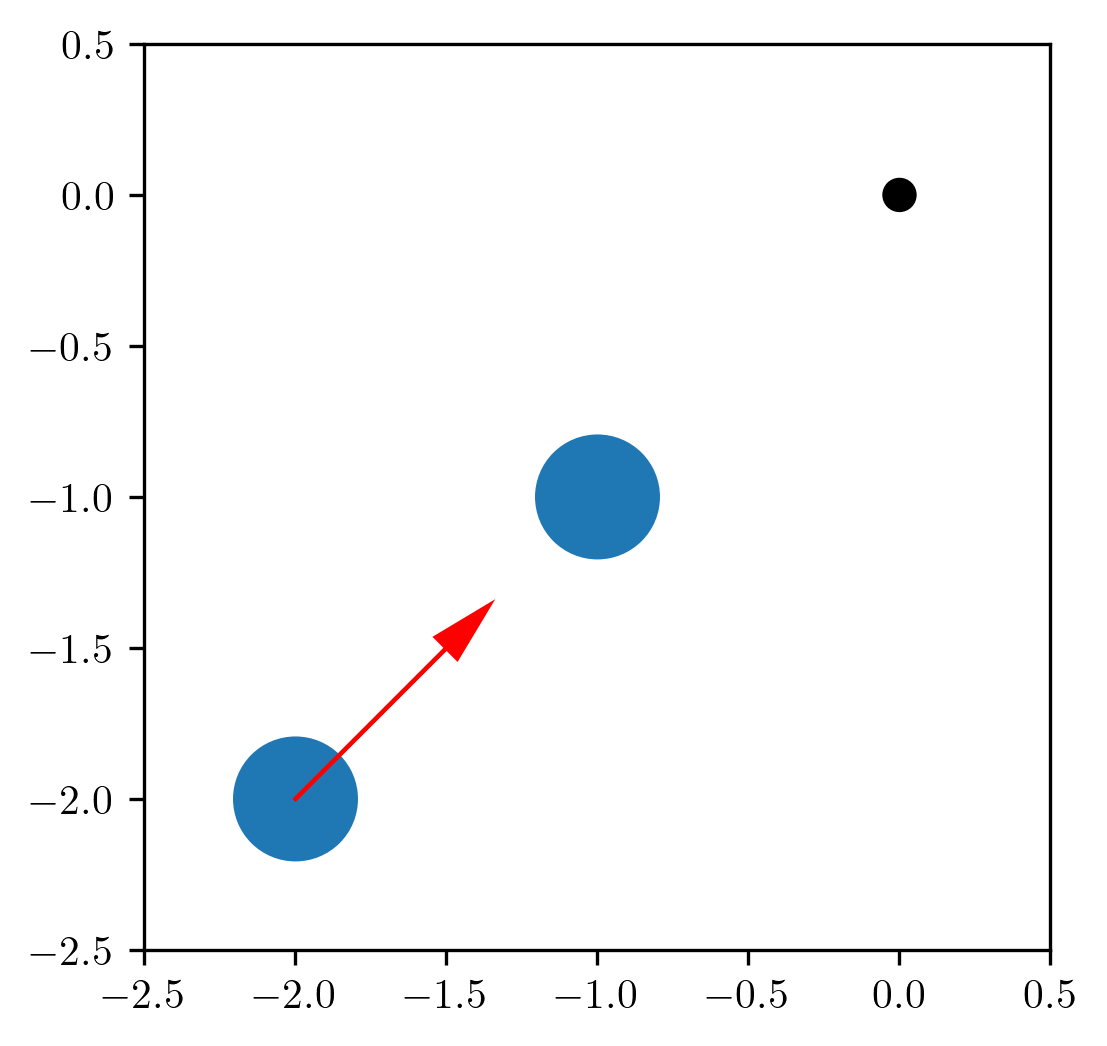

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax.set_aspect('equal')
ax.set(ylim=(-2.5, 0.5))
ax.set(xlim=(-2.5, 0.5))
# ax.plot(traj[:, 0].detach().cpu().numpy(), traj[:, 1].detach().cpu().numpy(), color='red')
circle_ball_1 = plt.Circle((-2., -2.), 0.2, color='tab:blue', fill=True)
ax.add_patch(circle_ball_1)
circle_ball_2 = plt.Circle((-1., -1.), 0.2, color='tab:blue', fill=True)
ax.add_patch(circle_ball_2)
target = plt.Circle((-0., -0.), 0.05, color='k', fill=True)
ax.add_patch(target)
ax.arrow(x=-2, y=-2, dx=0.5, dy=0.5, head_width=0.1, head_length=0.2, color='red', edgecolor='red')
# fig.savefig(os.path.join(FIG_DIR, "two_balls_traj.png"), bbox_inches="tight")